In [73]:
from transformers import BertForTokenClassification, BertTokenizer
from peft import PeftModel
import numpy as np
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.metrics.pairwise import cosine_similarity

In [74]:
num_tokens = [1, 5, 10, 20, 50]
num_epochs = [8, 10]
init_strategies = ['normal', 'random', 'task']
num_orig_ner_labels = 39

name = 'bert-base-multilingual-cased'

In [75]:
all_paths = []
for token in num_tokens:
    for init_strategy in init_strategies:
        for epoch in num_epochs:
            all_paths.append('soft_prompts/ner/' + str(token) + "/" + str(init_strategy) + "/" + str(epoch))

soft_prompts_path = 'soft_prompts/ner/20/task/10'

In [76]:
model = BertForTokenClassification.from_pretrained(name, num_labels=num_orig_ner_labels)
peft_model = PeftModel.from_pretrained(model, soft_prompts_path)
soft_prompts = peft_model.prompt_encoder['default'].embedding.weight.data

A parameter name that contains `beta` will be renamed internally to `bias`. Please use a different name to suppress this warning.
A parameter name that contains `gamma` will be renamed internally to `weight`. Please use a different name to suppress this warning.
A parameter name that contains `beta` will be renamed internally to `bias`. Please use a different name to suppress this warning.
A parameter name that contains `gamma` will be renamed internally to `weight`. Please use a different name to suppress this warning.
A parameter name that contains `beta` will be renamed internally to `bias`. Please use a different name to suppress this warning.
A parameter name that contains `gamma` will be renamed internally to `weight`. Please use a different name to suppress this warning.
A parameter name that contains `beta` will be renamed internally to `bias`. Please use a different name to suppress this warning.
A parameter name that contains `gamma` will be renamed internally to `weight`. Pl

In [77]:
soft_prompts.shape

torch.Size([20, 768])

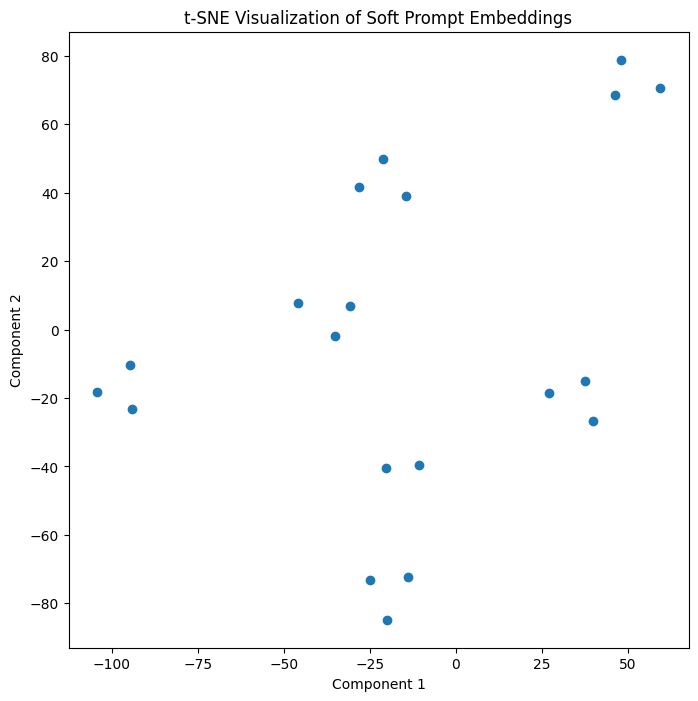

In [78]:
soft_prompt_embeddings_np = soft_prompts.detach().cpu().numpy()

tsne = TSNE(n_components=2, random_state=42, perplexity=4)
soft_prompt_2d = tsne.fit_transform(soft_prompt_embeddings_np)

plt.figure(figsize=(8, 8))
plt.scatter(soft_prompt_2d[:, 0], soft_prompt_2d[:, 1])
plt.title("t-SNE Visualization of Soft Prompt Embeddings")
plt.xlabel("Component 1")
plt.ylabel("Component 2")
plt.show()

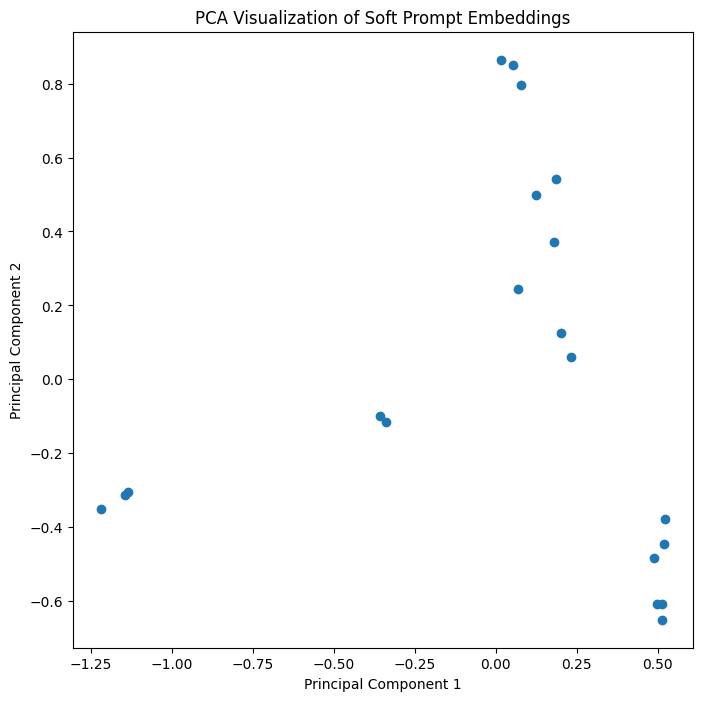

In [79]:
pca = PCA(n_components=2)
soft_prompt_2d_pca = pca.fit_transform(soft_prompt_embeddings_np)

plt.figure(figsize=(8, 8))
plt.scatter(soft_prompt_2d_pca[:, 0], soft_prompt_2d_pca[:, 1])
plt.title("PCA Visualization of Soft Prompt Embeddings")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.show()


In [80]:

tokenizer = BertTokenizer.from_pretrained('bert-base-multilingual-cased')

token_embeddings = model.get_input_embeddings().weight.detach().cpu().numpy()

# Compute cosine similarity between soft prompts and token embeddings
similarities = cosine_similarity(soft_prompt_embeddings_np, token_embeddings)

# Get the most similar tokens for each soft prompt embedding
most_similar_token_indices = np.argmax(similarities, axis=1)

# Decode the most similar tokens
for i, idx in enumerate(most_similar_token_indices):
    token = tokenizer.convert_ids_to_tokens(int(idx))
    print(f"Soft prompt {i}  corresponds to token: {token}")

Soft prompt 0  corresponds to token: [CLS]
Soft prompt 1  corresponds to token: entity
Soft prompt 2  corresponds to token: label
Soft prompt 3  corresponds to token: tag
Soft prompt 4  corresponds to token: identify
Soft prompt 5  corresponds to token: recognize
Soft prompt 6  corresponds to token: [SEP]
Soft prompt 7  corresponds to token: [CLS]
Soft prompt 8  corresponds to token: entity
Soft prompt 9  corresponds to token: label
Soft prompt 10  corresponds to token: tag
Soft prompt 11  corresponds to token: identify
Soft prompt 12  corresponds to token: recognize
Soft prompt 13  corresponds to token: [SEP]
Soft prompt 14  corresponds to token: [CLS]
Soft prompt 15  corresponds to token: entity
Soft prompt 16  corresponds to token: label
Soft prompt 17  corresponds to token: tag
Soft prompt 18  corresponds to token: identify
Soft prompt 19  corresponds to token: recognize


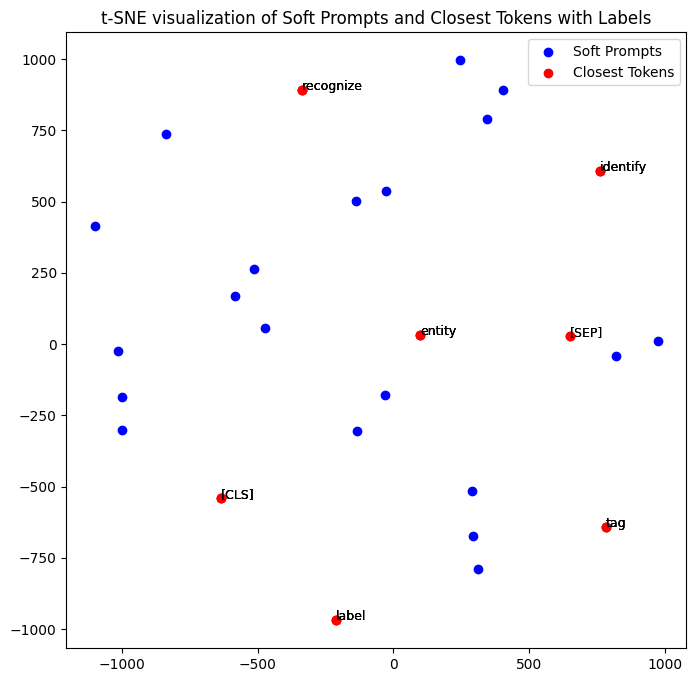

In [81]:
# Adjusting the code to include token annotations for the closest tokens in the t-SNE plot

# Assuming you have the token embeddings, soft prompt embeddings, and the closest tokens
embeddings_to_plot = np.vstack([soft_prompt_embeddings_np, token_embeddings[most_similar_token_indices]])
tsne = TSNE(n_components=2, perplexity=2, random_state=42)
embeddings_2d = tsne.fit_transform(embeddings_to_plot)

# Assuming tokenizer is loaded to convert token IDs into tokens
# tokenizer = BertTokenizer.from_pretrained('bert-base-multilingual-cased')

# Plot soft prompts and closest tokens
plt.figure(figsize=(8, 8))
plt.scatter(embeddings_2d[:len(soft_prompt_embeddings_np), 0], embeddings_2d[:len(soft_prompt_embeddings_np), 1], label="Soft Prompts", color='blue')
plt.scatter(embeddings_2d[len(soft_prompt_embeddings_np):, 0], embeddings_2d[len(soft_prompt_embeddings_np):, 1], label="Closest Tokens", color='red')

# Annotating closest tokens
for i, idx in enumerate(most_similar_token_indices):
    token = str(tokenizer.convert_ids_to_tokens(int(idx)))  # Replace this with actual token using tokenizer.convert_ids_to_tokens(int(idx))
    plt.text(embeddings_2d[len(soft_prompt_embeddings_np) + i, 0], embeddings_2d[len(soft_prompt_embeddings_np) + i, 1], token, fontsize=9)

plt.legend()
plt.title("t-SNE visualization of Soft Prompts and Closest Tokens with Labels")
plt.show()
